In [23]:
import numpy as np # Scientific computing library with lots of valuable methods
import pandas as pd # Library for data frames in python
from rdkit import Chem # Open-source cheminformatics and machine learning library
from rdkit.Chem import Descriptors # import of descriptors module to calculate descriptors
import time # library to count time
from multiprocessing import Pool # multiprocessing library with pooling of cores.
import multiprocessing as mp # multiprocessing library with
import matplotlib.pyplot as plt # Library for easy plotting

In [26]:
print ("Pandas version ",pd.__version__)
print ("Numpy version ",np.__version__)

Pandas version  0.23.4
Numpy version  1.13.3


# Import data
Data.csv contains all the tested substances for BRCA1 expression in the AID 624202
The file can be downloaded here: https://pubchem.ncbi.nlm.nih.gov/bioassay/624202#section=Top
Click "Download" -> "Data Table only" -> save

In [2]:
data = pd.read_csv("data.csv",low_memory=False);

# Import smiles data from txt file

The simplified molecular-input line-entry system (SMILES) is a specification in form of a line notation for describing the structure of chemical species using short ASCII strings. SMILES strings can be imported by most molecule editors for conversion back into two-dimensional drawings or three-dimensional models of the molecules. The smiles data file shows the molecule ids and their respective structure. It was downloaded here:
https://pubchem.ncbi.nlm.nih.gov/bioassay/624202#section=Top

Click on the "Download" tab -> select "tested substances" -> click "Download service" -> Chose "Smiles" as format and download. 

In [3]:
smilesData = pd.read_csv("smilesData.txt",sep="\t", header=None);
smilesData.columns = ['molSID','chemStruc']
smilesData.head()

,molSID,chemStruc
0,124899260,C1=CC=C(C=C1)CCCCOC2=CC=C(C=C2)CC(=O)NO
1,124899259,C1=CC=NC(=C1)COC2=CC=C(C=C2)CC(=O)NO
2,124899258,C1=CC=C(C=C1)CCCOC2=CC=C(C=C2)CC(=O)NO
3,124899257,CC(C)COC1=CC=C(C=C1)CC(=O)NO
4,124899256,CCCCCCCOC1=CC=C(C=C1)CC(=O)NO


The rdkit.Chem package has the Descriptors module available which has 200 descriptor calculation methods. The api contains more information on available descriptors:
http://www.rdkit.org/Python_Docs/rdkit.Chem.Descriptors-module.html

In [4]:
# Import a list of possible decsriptor calculation methods from the Descriptor Package.
descList = [i[0] for i in Descriptors._descList]
# Remove the first 5 rows 
data = data.loc[5:,['PUBCHEM_SID','PUBCHEM_ACTIVITY_SCORE']];

Because the full data file contains almost 400.000 substances we will select a subset of them. In genereal there are way more inactive molecules in the BRCA1 expression than actives.

In [5]:
inactives= data.loc[data.PUBCHEM_ACTIVITY_SCORE==0]
actives= data.loc[data.PUBCHEM_ACTIVITY_SCORE!=0]
print("Number of inactives is ",len(inactives))
print("Number of actives is ", len(actives))

Number of inactives is  364035
Number of actives is  13515


In [6]:
# Select samples of inactive and active substances to create a small dataset
selectedInactives = inactives.sample(350)
selectedActives = actives.sample(700)
smallDataset = pd.concat([selectedInactives,selectedActives])

In [7]:
smallDataset.head()

,PUBCHEM_SID,PUBCHEM_ACTIVITY_SCORE
342446,85270731.0,0.0
266238,49715795.0,0.0
98185,17414609.0,0.0
127227,22412465.0,0.0
20767,3713867.0,0.0


In [8]:
print("Shape of small dataset is",smallDataset.shape)

Shape of small dataset is (1050, 2)


In [9]:
# Convert floating point values to integers. 
smallDataset['PUBCHEM_SID'] = smallDataset['PUBCHEM_SID'].astype(np.int64)
smallDataset['PUBCHEM_ACTIVITY_SCORE'] = smallDataset['PUBCHEM_ACTIVITY_SCORE'].astype(np.int64)

In [10]:
smallDataset.head()

,PUBCHEM_SID,PUBCHEM_ACTIVITY_SCORE
342446,85270731,0
266238,49715795,0
98185,17414609,0
127227,22412465,0
20767,3713867,0


# Creating the descriptors Matrix

In [11]:
# subset the smiles data with the small dataset entries computed above.
smallSmilesData = smilesData.loc[smilesData.molSID.isin(smallDataset.PUBCHEM_SID.values)]

In [12]:
smallSmilesData.head()

,molSID,chemStruc
129,124897762,CN(C)C1=CC=C(C=C1)/C=C/C2=CN=CC3=CC=CC=C32
335,124897061,C1=CC=C2C(C=CC2=C1)C3=CC=C(C=C3)Br
683,124895798,CN(C)C1=CC(=C(C=C1)/C=C/C2=CC=NC3=CC=CC=C23)N
1554,124882850,C1=CC=C(C=C1)C2=CC(=O)C3=C(C(=C(C=C3O2)O)O)O
1994,124755697,COC1=CC=C(C=C1)C2=C(C3=C(O2)CCCC3OCCCO)C(=O)OCCO


To calculate the descriptors we create a descriptors matrix. By allocating memory beforehand we save the compiler to do that dynamically which will speed up the process.

In [13]:
dM = pd.DataFrame(np.zeros([len(smallSmilesData),len(descList)]))
dM.columns = descList
dM.insert(loc=0, column="molSID",value = smallSmilesData.molSID.values)
dM.insert(loc=1, column="chemStr",value = smallSmilesData.chemStruc.values)

In [14]:
dM.head()

,molSID,chemStr,NumValenceElectrons,MaxAbsPartialCharge,MaxEStateIndex,MaxAbsEStateIndex,MinEStateIndex,MaxPartialCharge,MinAbsEStateIndex,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,124897762,CN(C)C1=CC=C(C=C1)/C=C/C2=CN=CC3=CC=CC=C32,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,124897061,C1=CC=C2C(C=CC2=C1)C3=CC=C(C=C3)Br,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,124895798,CN(C)C1=CC(=C(C=C1)/C=C/C2=CC=NC3=CC=CC=C23)N,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,124882850,C1=CC=C(C=C1)C2=CC(=O)C3=C(C(=C(C=C3O2)O)O)O,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,124755697,COC1=CC=C(C=C1)C2=C(C3=C(O2)CCCC3OCCCO)C(=O)OCCO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
# to make the code easier readable we create lists of the chemical structures and the mol SIDs
chemStr = dM.chemStr.values
molSID = dM.molSID.values


# Multiprocessing module

The multiprocessing need careful consideration of how to distribute the data across the cores. The way the multiprocessing module works is by copying the method and a partition of the input data to each core. Thus interdependent calculations will need careful architecture and memory sharing. 

In [16]:
# The simpleCalcDesc method is designed to take the least amount of information, 
# which is only the moSIDs.
def simpleCalcDesc(molSID):
    # Lookup in the descriptor matrix and get the chemical structure for the specific molSID
    # This way we avoid comparing chemical structures where the information entropy is higher,
    # than the molSIDs, which could result in longer runtime.
    chemStr = dM.chemStr.values[dM.molSID==molSID][0]
    # create Chem molecule from smiles structure.
    m= Chem.MolFromSmiles(chemStr)
    # Iterate over descriptor calculation methods and compute the descriptor for the chemical structure.
    for idx,val in enumerate(descList): 
        # the getattr method is necessary in order to swich between the descriptor-class' methods 
        # the alternative would be e.g. Descriptors.MinEStateIndex(m) but the python compiler
        # need to know if the descriptor calculator is a string or if it needs to be executed.
        tempDescVal = getattr(Descriptors,val)(m)    
        # Update the value in the descriptor matrix with the calculated descriptor.
        dM.loc[dM.molSID == molSID, val] = tempDescVal
    return dM        

In [17]:
# This is a simple method for running the simpleCalcDesc method with the molSIDs computed above.
# The amount of available cores can be found by mp.cpu_count(). 
def runParallelProcessing(nCores,void):
    start = time.time()
    # The pool method creates a specified amount of cores which the workload will be distributed to.
    pool = mp.Pool(nCores)
    
    # Map distributes the method and data to each of the cores in the pool.
    result = pool.map(simpleCalcDesc,molSID)

    end = time.time()
    # Close and join pool of cores
    pool.close()
    pool.join()
    print("time to complete: ", end-start, " seconds")
    
    # If void don't return result array.
    if(void==True):
        return 
    
    return result

In [18]:
# Run multiprocessing module with 8 cores
result = runParallelProcessing(8,False)

time to complete:  148.91927909851074  seconds


In [19]:
# Run multiprocessing module with 6 cores
runParallelProcessing(6,True)

time to complete:  154.37864708900452  seconds


In [20]:
# Run multiprocessing module with 4 cores
runParallelProcessing(4,True)

time to complete:  159.6068229675293  seconds


In [21]:
# Run multiprocessing module with 2 cores
runParallelProcessing(2,True)

time to complete:  253.78030800819397  seconds


In [22]:
# Run multiprocessing module with 1 cores
runParallelProcessing(1,True)

time to complete:  458.5400581359863  seconds


# Reduce mapping output from parallel processing

Because the tasks have been spread out over multiple cores the result that returns is in fragments from each core, thus we have to combine the fragments in the process of reducing. 

Each core has its own memory allocation and during the mapping process the memory is a snapshot of the variables. There are ways to implement memory sharing but I haven't been able to get that working, therefore I will have to slice the results matrix in the following way.

In [24]:
descriptorMatrix = pd.DataFrame()

# iterate over each of the result matrices returned by the pool of cores.
# The result matrix is a 1050 structure where each entry contains the computed descriptor values
# for one molSID.
for i in range(len(result)):
    # because each core has been assigned one molecule per return matrix,
    # we can simply select the same row of the index of that particular resultmatrix.
    temp = pd.DataFrame(result[i].iloc[i]).T
    # Append to final descriptor matrix
    descriptorMatrix = temp.append(descriptorMatrix)
    
descriptorMatrix = descriptorMatrix.sort_index()

In [25]:
descriptorMatrix.head()

,molSID,chemStr,NumValenceElectrons,MaxAbsPartialCharge,MaxEStateIndex,MaxAbsEStateIndex,MinEStateIndex,MaxPartialCharge,MinAbsEStateIndex,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,124897762,CN(C)C1=CC=C(C=C1)/C=C/C2=CN=CC3=CC=CC=C32,104,0.377661,4.3045,4.3045,1.14332,0.0360916,1.14332,0,...,0,0,0,0,0,0,0,0,0,0
1,124897061,C1=CC=C2C(C=CC2=C1)C3=CC=C(C=C3)Br,78,0.0720204,3.46773,3.46773,0.420648,0.0278259,0.420648,0,...,0,0,0,0,0,0,0,0,0,0
2,124895798,CN(C)C1=CC(=C(C=C1)/C=C/C2=CC=NC3=CC=CC=C23)N,110,0.398182,6.1457,6.1457,0.778529,0.0707469,0.778529,0,...,0,0,0,0,0,0,0,0,0,0
3,124882850,C1=CC=C(C=C1)C2=CC(=O)C3=C(C(=C(C=C3O2)O)O)O,100,0.504068,12.0445,12.0445,-0.738647,0.20085,0.00384543,0,...,0,0,0,0,0,0,0,0,0,0
4,124755697,COC1=CC=C(C=C1)C2=C(C3=C(O2)CCCC3OCCCO)C(=O)OCCO,152,0.496768,12.8159,12.8159,-0.539328,0.342067,0.0490686,0,...,0,0,0,0,0,0,0,0,1,0


# Conclusion

Following plot clearly shows the nature of compute time and parallelisation.

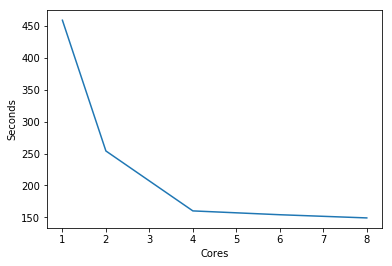

In [31]:
plt.plot([1,2,4,6,8],[459,254,160,154,149])
plt.xlabel('Cores')
plt.ylabel('Seconds')
plt.show()

# Possible future leads

This section covers aspects that could be interesting to pursuit in the future so I have decided to keep it in the notebook. The three main leads are:
1. queuing output files to reduce output of parallel processes
2. Parallelising full descriptor dataframe instead of sending individual molecule ids, the idea is to split the dataframe in parts and send the parts to each of the cores.
3. Sharing memory space of cores with pipes. 

In [ ]:
output = mp.Queue()
mp.cpu_count()

In [ ]:
def calculateDescriptor(descriptor, chemStr,molSID):
    for idx,val in enumerate(molSID):
        m= Chem.MolFromSmiles(chemStr[idx])
        descVal = Descriptors.MaxAbsPartialCharge(m)
        dM.loc[dM.molSID == val, descriptor] = descVal


In [ ]:
def parallelize_dataframe(df, func):
    df_split = np.array_split(df, num_partitions)
    pool = Pool(num_cores)
    df = pd.concat(pool.map(func, df_split))
    pool.close()
    pool.join()
    return df

In [ ]:
result = parallelize_dataframe(exDescM,calculateDescriptors)

In [ ]:
for idx,val in enumerate(smallSmilesData.chemStruc.values):
    m = Chem.MolFromSmiles(val)
    descriptor = descList[idx]
    tempDescVal = getattr(Descriptors,descriptor)(m)
    print(tempDescVal)
    break

In [ ]:
descriptorsMatrix = pd.DataFrame(np.zeros([len(smallSmilesData),len(descList)]))
descriptorsMatrix.columns = descList
descriptorsMatrix.insert(loc=0, column="molSID",value = smallSmilesData.molSID.values)

# Mini dataframe


In [ ]:
extraSmallData = smallSmilesData[:5]

In [ ]:
exDescM = pd.DataFrame(np.zeros([len(extraSmallData),len(descList)]))
exDescM.columns = descList
exDescM.insert(loc=0, column="molSID",value = extraSmallData.molSID.values)
exDescM.insert(loc=1, column="chemStr",value = extraSmallData.chemStruc.values)

In [ ]:
exDescM

# mini end

# method for calculating descriptors for full matrix

In [ ]:
def calculateDescriptors(descriptorsMatrix):
    descList = list(descriptorsMatrix.columns.values)
    descList.remove('molSID')
    descList.remove('chemStruc')
    chemStruc = exDescM.chemStruc.values
    for i, mol in enumerate(descriptorsMatrix.molSID):
        m= Chem.MolFromSmiles(chemStruc[i])
        for idx, val in enumerate(descList): 
            descriptor = descList[idx]
            tempDescVal = getattr(Descriptors,descriptor)(m)
            descriptorsMatrix.loc[descriptorsMatrix.molSID == mol , descriptor] = tempDescVal 